In [1]:
# 20-12-2020 Most Extensive Experiment Analysis

In [3]:
# Models used in saved Neural Network
using Knet: Knet, AutoGrad, dir, Data, minibatch, Param, @diff, value, params, grad, progress, progress!, KnetArray
using IterTools
using Base.Iterators
using Knet: Ops20.zeroone
using Printf, Random, Test, Statistics
using Plots; default(fmt=:png)
include("../utils.jl")

# Define Linear Model
struct Linear; w; b; end
Linear(i::Int,o::Int) = Linear(param(o, i), param0(o))
(m::Linear)(x) = m.w * x .+ m.b
(m::Linear)(x, y) = Knet.nll(m(x), y)
(m::Linear)(data::Knet.Data) = mean(m(x, y) for (x, y) in data)

# MLP Layer - f: can be identity, relu etc,  - pdrop: dropout rate
struct MLPLayer; w; b; f; pdrop; end
MLPLayer(i::Int,o::Int,f=relu; pdrop=0) = MLPLayer(param(o, i), param0(o), f, pdrop)
(l::MLPLayer)(x) = l.f.(l.w * dropout(x, l.pdrop) .+ l.b)

# Define convolutional layer:
struct Conv2; w; b; f; is_pool_enabled::Bool; end
Conv2(w1,w2,nx,ny, f=relu; is_pool_enabled=true) = Conv2(param(w1, w2, nx, ny), param0(1, 1, ny, 1), f, is_pool_enabled)
function (c::Conv2)(x) 
    if c.is_pool_enabled
        pool(c.f.(conv4(c.w, x) .+ c.b))
    else
        c.f.(conv4(c.w, x) .+ c.b)
    end
end

# Define dense layer:
struct Dense; w; b; f; p; end
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o, i), param0(o), f, pdrop)
Dense(w, b; f=identity, pdrop=0) = Dense(param(w; atype=Knet.atype()), param(b; atype=Knet.atype()), f, pdrop)
(d::Dense)(x) = d.f.(d.w * mat(dropout(x, d.p)) .+ d.b) 

# Define a chain of layers and a loss function:
struct DeeperCutOption
    connect_res3_to_res5::Bool
end

#=
struct Chain
    layers; lambda1; lambda2; loss; deeperCutOption
    Chain(layers...; lambda1=0, lambda2=0, loss=nll, deeperCutOption=nothing) = new(layers, lambda1, lambda2, loss, deeperCutOption)
end

# The prediction and average loss do not change
function (c::Chain)(x)  
    connection_from3_to5 = nothing;
    for l in c.layers    
         x = l(x)
        
        if c.deeperCutOption.connect_res3_to_res5 
            layer_tag = get_object_tag(l)
            if layer_tag == 3 
                connection_from3_to5 = l.conv3_for_deepercut_output(x)
            end
        end
        
        if c.deeperCutOption.connect_res3_to_res5 
            layer_tag = get_object_tag(l)
            if layer_tag == "part_detect_deconv" 
                x = x .+ connection_from3_to5 
            end
        end
         
    end 
    
    x
end

function (c::Chain)(x, y)
    loss = c.loss(c(x), y)
    if training() # Only apply regularization during training, only to weights, not biases.
        c.lambda1 != 0 && (loss += c.lambda1 * sum(sum(abs, l.w) for l in c.layers))
        c.lambda2 != 0 && (loss += c.lambda2 * sum(sum(abs2, l.w) for l in c.layers))
    end
    return loss
end
(c::Chain)(d::Data) = mean(c(x, y) for (x, y) in d)
=#

#=
struct Deconv; w; stride; padding; tag::String; end
Deconv(w1, w2, nx, ny; stride=1, padding=0, atype=Knet.atype(), tag="") = Deconv(param(w1, w2, nx, ny;atype=atype), stride, padding, tag)

(dc::Deconv)(x) = deconv4(dc.w, x; stride=dc.stride, padding=dc.padding)
=#

# This became redundant now
struct ResLayerConv; w; padding; stride; end
# Random init
ResLayerConv(w1, w2, nx, ny; padding=0, stride=1) = ResLayerConv(param(w1, w2, nx, ny), padding, stride)
# Predeterminde weights
ResLayerConv(w; padding=0, stride=1) = ResLayerConv(param(w), padding, stride)
(rl0::ResLayerConv)(x) = conv4(rl0.w, x; padding=rl0.padding, stride=rl0.stride)

struct BatchNormLayer; w; ms; 

    function BatchNormLayer(pre_w, pre_ms)
        res_mean = popfirst!(pre_ms)
        # Trick to arrange variance value for new(er) batchnorm
        res_variance =   popfirst!(pre_ms).^2  .- 1e-5
        ms = bnmoments(mean=res_mean, var=res_variance)
    
        w1 = pre_w[1]
        w2 = pre_w[2]
        w1 = vec(w1)
        w2 = vec(w2)
        w =  vcat(w1, w2)
        param_w = param(w, atype=Knet.atype())
        return new(param_w, ms)
    end

end

function (batch_norm_layer::BatchNormLayer)(x)
    return batchnorm(x, batch_norm_layer.ms, batch_norm_layer.w; eps=1e-5)
end 

# ResNet 50 initial layer
struct ResLayerX1_50;
    batch_layer;
    conv_w;
    conv_b;
    padding;
    stride;
    pool_window_size;
    pool_stride;
    pool_padding;
end

function ResLayerX1_50(w, ms; padding=3, stride=2, pool_window_size=3, pool_stride=2, pool_padding=1)
    bnl = BatchNormLayer(w[3:4], ms)
    return ResLayerX1_50(bnl,
        param(w[1]; atype=Knet.atype()),
        param(w[2]; atype=Knet.atype()),
        padding,
        stride,
        pool_window_size,
        pool_stride,
    pool_padding)
end

function (rlx1_50::ResLayerX1_50)(x)
    o = conv4(rlx1_50.conv_w, x; padding=rlx1_50.padding, stride=rlx1_50.stride) .+ rlx1_50.conv_b
    o = rlx1_50.batch_layer(o)
    o = relu.(o)
    o = pool(o; window=rlx1_50.pool_window_size, stride=rlx1_50.pool_stride, padding=rlx1_50.pool_padding)
    return o
end

# X0
struct ResLayerX0; batch_layer; conv_w; padding; stride; dilation; end
# Predetermined weights
# TODO: should we try to make bnl params??
function ResLayerX0(w, ms; padding=0, stride=1, dilation=1)
    bnl = BatchNormLayer(w[2:3], ms)
    return   ResLayerX0(
        bnl,        
        param(w[1]; atype=Knet.atype()), 
        padding, 
        stride,
        dilation
    )
end

function (rlx0::ResLayerX0)(x) 
   # batchnorm_as_function(rlx0.batch_w, conv4(rlx0.conv_w, x; padding=rlx0.padding, stride=rlx0.stride), rlx0.ms) 
    o = conv4(rlx0.conv_w, x; padding=rlx0.padding, stride=rlx0.stride, dilation=rlx0.dilation)
    o = rlx0.batch_layer(o)
    return o
end

# X1
struct ResLayerX1; x0_layer; is_initial::Bool; end
ResLayerX1(w, ms; padding=0, stride=1, is_initial::Bool=false, dilation=1) = ResLayerX1(ResLayerX0(w, ms; padding=padding, stride=stride, dilation=dilation), is_initial)
function (rlx1::ResLayerX1)(x)
    relu_res = relu.(rlx1.x0_layer(x))
    if rlx1.is_initial
        return pool(relu_res; window=3, stride=2)
    else
        return relu_res
    end
end


# X2
# TODO: can be constructed like Chain
struct ResLayerX2; x1_a_layer; x1_b_layer; x0_c_layer; end
ResLayerX2(w, ms; pads=[0, 1, 0], strides=[1, 1, 1], dilations=[1,1,1]) = ResLayerX2(
    ResLayerX1(w[1:3], ms; padding=pads[1], stride=strides[1], dilation=dilations[1]),
    ResLayerX1(w[4:6], ms; padding=pads[2], stride=strides[2], dilation=dilations[2]),
    ResLayerX0(w[7:9], ms; padding=pads[3], stride=strides[3], dilation=dilations[3])
    )
(rlx2::ResLayerX2)(x) =   rlx2.x0_c_layer(rlx2.x1_b_layer((rlx2.x1_a_layer(x))))


# X3
struct ResLayerX3; x0_a_layer::ResLayerX0; x2_b_layer::ResLayerX2; end
ResLayerX3(w, ms; pads=[0, 0, 1, 0], strides=[2, 2, 1, 1], b_layer_dilations=[1, 1, 1]) = ResLayerX3(
    ResLayerX0(w[1:3], ms; padding=pads[1], stride=strides[1]),
    ResLayerX2(w[4:12], ms; pads=pads[2:4], strides=strides[2:4], dilations=b_layer_dilations)
    )
function (rlx3::ResLayerX3)(x)
    res_a = rlx3.x0_a_layer(x)
    res_b = rlx3.x2_b_layer(x)
    return relu.(res_a .+ res_b)
end


# X4
struct ResLayerX4;  x2_layer; end
ResLayerX4(w, ms; pads=[ 0, 1, 0], strides=[1, 1, 1], dilations=[1,1,1]) = ResLayerX4(
    ResLayerX2(w, ms; pads=pads, strides=strides, dilations=dilations)
    )
(rlx4::ResLayerX4)(x) =   relu.(x .+ rlx4.x2_layer(x))


# X5
#=
struct ResLayerX5;
    x3_layer::ResLayerX3;
    x4_layers; 
    is_next_fc::Bool;
    conv3_for_deepercut_output;
    tag;
end


function ResLayerX5(w, ms; 
        strides=[2, 2, 1, 1],
        is_next_fc::Bool=false, 
        b_layer_dilations=[1, 1, 1],
        b_layer_pads=[0, 1, 0],
        is_conv3_for_deepercut=false,
        tag=nothing
    )
    x3_layer::ResLayerX3 = ResLayerX3(w[1:12], ms; strides=strides)
    x4_layers = []
    for k = 13:9:length(w)
        layer = ResLayerX4(w[k:k + 8], ms; dilations=b_layer_dilations, pads=b_layer_pads)
        push!(x4_layers, layer)
    end
    
    conv3_for_deepercut_output = nothing
    if is_conv3_for_deepercut
            # 14 layer for part detection
        conv3_for_deepercut_output = Conv2(1, 1, 512, global_num_joints, identity; is_pool_enabled=false)
    end
    
    return ResLayerX5(x3_layer, x4_layers, is_next_fc, conv3_for_deepercut_output, tag)
    end 
=#

#=
function (rlx5::ResLayerX5)(x) 
    x = rlx5.x3_layer(x)
    for l in rlx5.x4_layers
        x = l(x)
    end

    if rlx5.is_next_fc
        return pool(x; stride=1, window=7, mode=2)
    else
        return x
    end
    end 
=#

# OLD IMPLEMENTATIONS's 

struct ResLayerX5;
    x3_layer::ResLayerX3;
    x4_layers; 
    is_next_fc::Bool;
end

function (rlx5::ResLayerX5)(x) 
    x = rlx5.x3_layer(x)
    for l in rlx5.x4_layers
        x = l(x)
    end

    if rlx5.is_next_fc
        return pool(x; stride=1, window=7, mode=2)
    else
        return x
    end
    end 

function ResLayerX5(w, ms; 
        strides=[2, 2, 1, 1],
        is_next_fc::Bool=false, 
        b_layer_dilations=[1, 1, 1],
        b_layer_pads=[0, 1, 0]
    )
    x3_layer::ResLayerX3 = ResLayerX3(w[1:12], ms; strides=strides)
    x4_layers = []
    for k = 13:9:length(w)
        layer = ResLayerX4(w[k:k + 8], ms; dilations=b_layer_dilations, pads=b_layer_pads)
        push!(x4_layers, layer)
    end
    return ResLayerX5(x3_layer, x4_layers, is_next_fc)
end 

struct Deconv; w; stride; padding; end
Deconv(w1, w2, nx, ny; stride=1, padding=0, atype=Knet.atype()) = Deconv(param(w1, w2, nx, ny;atype=atype), stride, padding)
(dc::Deconv)(x) = deconv4(dc.w, x; stride=dc.stride, padding=dc.padding)

struct Chain
    layers; lambda1; lambda2; loss;
    Chain(layers...; lambda1=0, lambda2=0, loss=nll) = new(layers, lambda1, lambda2, loss)
end

# The prediction and average loss do not change
function (c::Chain)(x)  
    for l in c.layers    
         x = l(x)     
    end 
    x
end

function (c::Chain)(x, y)
    loss = c.loss(c(x), y)
    if training() # Only apply regularization during training, only to weights, not biases.
        c.lambda1 != 0 && (loss += c.lambda1 * sum(sum(abs, l.w) for l in c.layers))
        c.lambda2 != 0 && (loss += c.lambda2 * sum(sum(abs2, l.w) for l in c.layers))
    end
    return loss
end
(c::Chain)(d::Data) = mean(c(x, y) for (x, y) in d)

In [31]:
include("../training.jl")
include("../plots.jl")
include("../helper.jl")
include("accuracy.jl")
include("loss.jl")
include("../training.jl")

compute_error_in_training (generic function with 1 method)

In [5]:
loaded_batches = Knet.load("20-12-2020-24kimage-batches.jld2", "24k-image-batches");
dtrn, dval = loaded_batches;
dtrn_x1, dtrn_y1 = first(dtrn)
dval_x1, dval_y1 = first(dval)
resnet_with_deconv = Knet.load("20-+5ep-12-2020-24kimage-resnet-50.jld2", "resnet_with_deconv");

In [81]:
wrong_scs_gt = []
wrong_scs_pred = []
wrong_scs_pred_initial = []
wrong_scs_cache= [wrong_scs_gt, wrong_scs_pred, wrong_scs_pred_initial];

In [82]:
modelized_naive_pck_sigm_with_wrong_cache(resnet_with_deconv, dval, wrong_scs_cache)

0.4097842261904763

In [70]:
wrong_scs_gt;

In [188]:
wrong_idx = 136

136

In [189]:
# 43008 Total number of Joints
test_y = wrong_scs_gt[ wrong_idx ];
test_y_pred = wrong_scs_pred[wrong_idx];
test_y_pred_initial = wrong_scs_pred_initial[wrong_idx];

In [190]:
#findall(x -> x[12, 12] == 1  , wrong_scs_gt )

In [191]:
max = argmax(test_y_pred_initial)
println(max)
test_y_pred_initial[max]

CartesianIndex(9, 17)


0.59941936f0

In [192]:
findall(x->x==1, test_y)

15-element Array{CartesianIndex{2},1}:
 CartesianIndex(9, 10)
 CartesianIndex(10, 10)
 CartesianIndex(11, 10)
 CartesianIndex(8, 11)
 CartesianIndex(9, 11)
 CartesianIndex(10, 11)
 CartesianIndex(11, 11)
 CartesianIndex(8, 12)
 CartesianIndex(9, 12)
 CartesianIndex(10, 12)
 CartesianIndex(11, 12)
 CartesianIndex(12, 12)
 CartesianIndex(9, 13)
 CartesianIndex(10, 13)
 CartesianIndex(11, 13)

In [193]:
max_gt = argmax(test_y)

CartesianIndex(9, 10)

In [194]:
test_y[max_gt]

1.0f0

,,

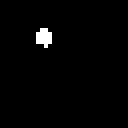
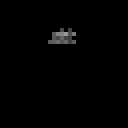
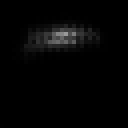

In [195]:
to_be_shown = [colorview(Gray, test_y),
colorview(Gray, test_y_pred),
colorview(Gray, test_y_pred_initial)]